# K-Line Factor Engineering (Multi-Asset Panel Data)

This notebook demonstrates factor calculation and backtesting using Panel Data format.

**Features:**
- **PanelData**: Unified multi-asset data format (DataFrame with rows=timestamps, cols=assets)
- **TS Operators**: Time-series operators that work on each asset independently
- **CS Operators**: Cross-sectional operators that work across assets at each timestamp
- **Backtest**: Factor value directly used as position (direct mode)

## 1. Setup and Imports

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# FactorLib imports - Panel Data API
from factorlib.cli import (
    load_panel_data_parquet,  # 从 parquet 加载（推荐）
    load_panel_data,          # 从 ClickHouse 加载
    backtest_panel,           # Panel Data 回测
    backtest,                 # data_dict 回测（兼容）
    PanelData,                # PanelData 类
)
from factorlib.utils import (
    ops,                  # 算子（支持 TS + CS）
    compute_factor_panel, # Panel 因子计算
    compute_factor,       # data_dict 因子计算（兼容）
)
from factorlib.utils.config import get_max_workers
from factorlib.factors.library import library

# Parallel workers configuration
MAX_WORKERS = get_max_workers(frac=0.8)
print(f"Parallel workers: {MAX_WORKERS} (CPU cores: {os.cpu_count()})")
print(f"Available factors: {library.list_factors()}")

Parallel workers: 76 (CPU cores: 96)
Available factors: ['ret_skew', 'momentum', 'mom_reversal', 'momentum_ma', 'volatility', 'atr', 'realized_vol', 'buy2sell_ratio', 'volume_anomaly', 'price_stable', 'price_range', 'price_position', 'trend_strength', 'atr_trend', 'trade_count_anomaly', 'trade_value_anomaly', 'volume_ratio', 'money_ratio', 'lbr_mom_5m', 'ma_ratio_momentum', 'mom_residue']


## 2. Load Data as PanelData

Load multi-asset data into unified `PanelData` format from local parquet files.

**Data Source:** `/home/ch/data/labels/OKX_1m_candles_data_agg/`

**PanelData format:**
- Each attribute (Close, Open, Volume, return, etc.) is a DataFrame
- Rows = timestamps, Columns = assets
- Supports both TS and CS operators directly

In [3]:
# Configure instruments to load
import json
with open('/home/ch/data/code_list.json', 'r') as f:
    code_dict = json.load(f)
INSTRUMENTS = code_dict['key5']
START_DATE = '2022-01-01 00:00:00'
DATA_NAME = 'OKX_1m_candles_data_agg' # 1 分钟 K 线数据
KLINE_DIR=f'/home/ch/data/labels/OKX/{DATA_NAME}'  # 默认路径
ORDERBOOK_DIR=f'/home/ch/data/orderbooks/OKX_PERP'  # 默认路径

# ============================================================
# 从 Parquet 文件加载数据（推荐）
# ============================================================
panel = load_panel_data_parquet(
    instruments=INSTRUMENTS,
    start_date=START_DATE,
    max_workers=MAX_WORKERS,
    data_dir=KLINE_DIR,  # 默认路径
    orderbook_dir=ORDERBOOK_DIR,  # 默认路径
    ob_levels=5,  # 订单簿深度等级
    use_cache=True  # 启用缓存
)

# 查看 PanelData 信息
panel.info()

# PanelData 使用方式：
# panel.Close      -> DataFrame (rows=时间, cols=资产)
# panel['return']  -> DataFrame
# panel.columns    -> 所有可用列
# panel.assets     -> 资产列表

# # 禁用缓存（每次从原始文件读取）
# from factorlib.utils.orderbook_loader import add_orderbook_to_panel
# add_orderbook_to_panel(panel, use_cache=False)

#   # 清除缓存
#   from factorlib.utils.orderbook_loader import clear_cache
#   clear_cache()  # 清除所有
#   clear_cache('BTC-USDT')  # 清除特定品种

Loading 5 instruments from parquet (/home/ch/data/labels/OKX/OKX_1m_candles_data_agg)...
Loaded PanelData: 2,046,718 timestamps x 5 assets
Assets: ['BTC-USDT-SWAP', 'ETH-USDT-SWAP', 'SOL-USDT-SWAP', 'XRP-USDT-SWAP', 'ADA-USDT-SWAP']
Loading orderbook data for 5 instruments...
  Parameters:
    - start_date: 2022-01-01
    - end_date: 2025-11-23
    - ob_levels: 5
    - orderbook_dir: /home/ch/data/orderbooks/OKX_PERP
    - cache_dir: /home/ch/data/feature_research/orderbook_cache
    - use_cache: True
Loaded orderbook for 3/5 instruments
Added 20 orderbook columns to panel
PanelData:
  Assets: 5 (BTC-USDT-SWAP, ETH-USDT-SWAP, SOL-USDT-SWAP, XRP-USDT-SWAP, ADA-USDT-SWAP)
  Time range: 2022-01-01 00:00:59.999000+00:00 -> 2025-11-23 15:59:59.999000+00:00
  Shape: 2,046,718 timestamps x 5 assets
  Columns: ['Close', 'Open', 'High', 'Low', 'Volume', 'return', 'QuoteAssetVolume', 'TakerBuyBaseAssetVolume', 'TakerSellBaseAssetVolume', 'TakerBuyQuoteAssetVolume', 'TakerSellQuoteAssetVolume', '

## 3. Factor Calculation with Panel Data

Define and compute factors using PanelData format.

**Operator Types:**
- **TS operators** (`ts_mean`, `ts_zscore`, etc.): Apply to each asset column independently
- **CS operators** (`cs_rank`, `cs_zscore`, etc.): Apply across assets at each timestamp

**Example Factor:**
```python
def my_factor(panel, ops):
    ret = panel['return']              # DataFrame (rows=time, cols=assets)
    ts_zscore = ops.ts_zscore(ret, 60) # TS: per asset
    cs_rank = ops.cs_rank(ts_zscore)   # CS: cross-sectional rank
    return ops.ts_ema(cs_rank, 2)
```

In [4]:
# ============================================================
# Panel Factor Definition - 支持 TS + CS 混合算子
# ============================================================

FACTOR_NAME = 'panel_factor'

def factor(panel, ops):
    """
    Panel Factor - 直接在 PanelData 上计算
    
    panel['Close'] 返回 DataFrame (rows=时间, cols=资产)
    TS 算子对每列独立计算，CS 算子跨列计算
    """
    # 提取基础数据（都是 DataFrame）
    quote_vol = panel['QuoteAssetVolume']
    ret = panel['return']
    open_price = panel['Open']
    close = panel['Close']
    
    # ========== TS 算子（对每个资产独立计算）==========
    ts_max_vol = ops.ts_max(quote_vol, 120)
    highday_ret = ops.highday(ret, 120)
    highday_open_240 = ops.highday(open_price, 240)
    highday_open_10 = ops.highday(open_price, 10)
    
    # 组合
    mul_1 = ops.multiply(ts_max_vol, highday_ret)
    mul_2 = ops.multiply(highday_open_240, close)
    mul_3 = ops.multiply(mul_1, mul_2)
    
    log_val = ops.log(highday_open_10)
    decay_1 = ops.decay_linear(log_val, 5)
    mul_4 = ops.multiply(mul_3, decay_1)
    decay_2 = ops.decay_linear(mul_4, 5)
    
    sign_val = ops.sign(decay_2)
    zscore_final = ops.ts_zscore(sign_val, 5495)
    factor_val = ops.clip(zscore_final, -3.0, 3.0)
    
    return factor_val


# ============================================================
# 计算因子（新方式：使用 PanelData）
# ============================================================
factor_panel = compute_factor_panel(panel, factor, FACTOR_NAME)

# factor_panel 是 DataFrame (rows=时间, cols=资产)
print(f"\nFactor shape: {factor_panel.shape}")
print(f"Factor columns (assets): {list(factor_panel.columns)}")

[panel_factor] Formula: clip(ts_zscore(sign(decay_linear((((ts_max(data, 120) * highday(data, 120)) * (highday(data, 240) * data)) * decay_linear(log(highday(data, 10)), 5)), 5)), 5495), -3.0, 3.0)

Factor shape: (2046718, 5)
Factor columns (assets): ['BTC-USDT-SWAP', 'ETH-USDT-SWAP', 'SOL-USDT-SWAP', 'XRP-USDT-SWAP', 'ADA-USDT-SWAP']


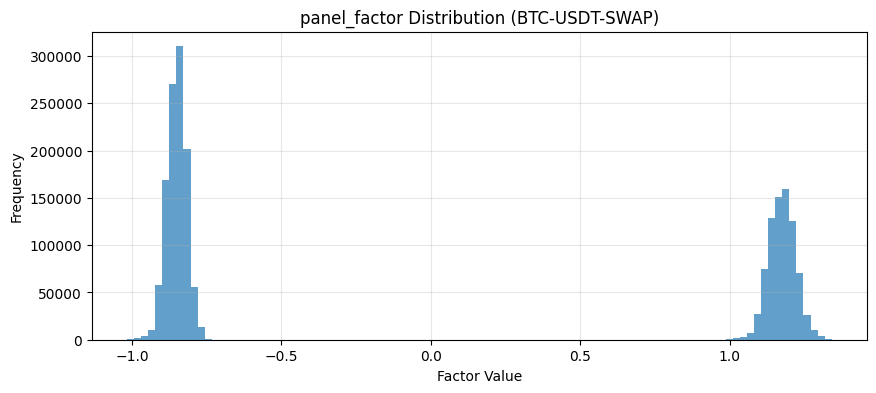

Heatmap data shape: (4320, 5)
Time range: 2025-06-01 00:00:59.999000+00:00 ~ 2025-06-03 23:59:59.999000+00:00


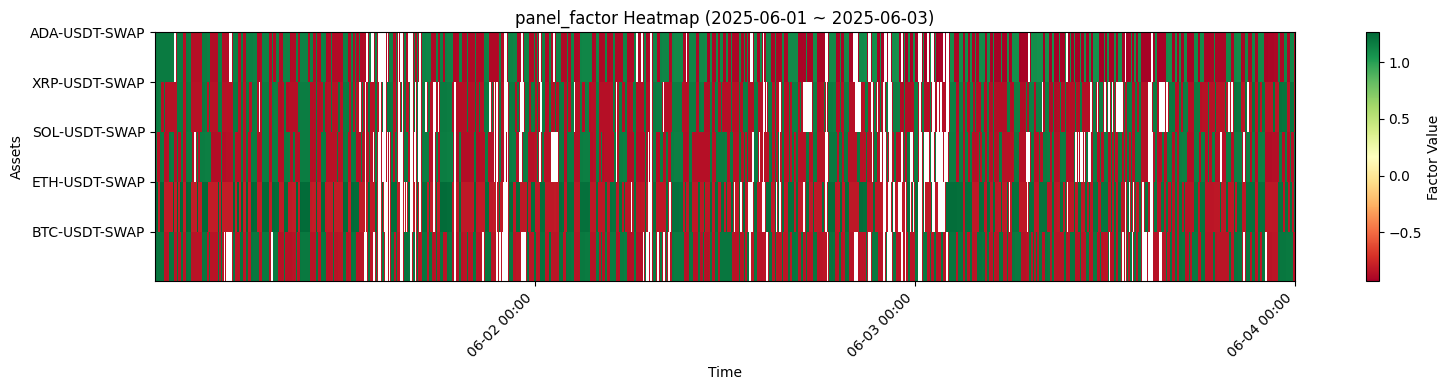

In [5]:
# 查看因子分布（选择一个资产）
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sample_asset = panel.assets[0]
plt.figure(figsize=(10, 4))
plt.hist(factor_panel[sample_asset].dropna(), bins=100, alpha=0.7)
plt.title(f'{FACTOR_NAME} Distribution ({sample_asset})')
plt.xlabel('Factor Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# ============================================================
# 热力图配置
# ============================================================
SHOW_HEATMAP = True  # 是否显示热力图

# 时间范围配置 - 支持以下格式:
# 1. 单个日期: '2025-01-15' (显示该天的数据)
# 2. 时间段: ('2025-01-01', '2025-01-15') (显示该时间段)
# 3. 年份: '2025', '2024', '2023', '2022'
# 4. 特殊选项: 'last_1000', 'all'
HEATMAP_TIME_RANGE = ('2025-06-01', '2025-06-03')  # 示例：时间段

if SHOW_HEATMAP:
    # 根据选项筛选数据
    if isinstance(HEATMAP_TIME_RANGE, tuple) and len(HEATMAP_TIME_RANGE) == 2:
        # 时间段: ('start_date', 'end_date')
        start_dt, end_dt = HEATMAP_TIME_RANGE
        heatmap_data = factor_panel.loc[start_dt:end_dt]
        title_suffix = f'({start_dt} ~ {end_dt})'
    elif isinstance(HEATMAP_TIME_RANGE, str):
        if HEATMAP_TIME_RANGE == 'last_1000':
            heatmap_data = factor_panel.tail(1000)
            title_suffix = '(last 1000 rows)'
        elif HEATMAP_TIME_RANGE == 'all':
            heatmap_data = factor_panel
            title_suffix = '(all time)'
        elif len(HEATMAP_TIME_RANGE) == 4 and HEATMAP_TIME_RANGE.isdigit():
            # 年份筛选
            year = int(HEATMAP_TIME_RANGE)
            heatmap_data = factor_panel[factor_panel.index.year == year]
            title_suffix = f'({HEATMAP_TIME_RANGE})'
        elif len(HEATMAP_TIME_RANGE) == 10:
            # 单个日期: '2025-01-15'
            heatmap_data = factor_panel.loc[HEATMAP_TIME_RANGE]
            title_suffix = f'({HEATMAP_TIME_RANGE})'
        else:
            heatmap_data = factor_panel.tail(1000)
            title_suffix = '(last 1000 rows)'
    else:
        heatmap_data = factor_panel.tail(1000)
        title_suffix = '(last 1000 rows)'
    
    print(f"Heatmap data shape: {heatmap_data.shape}")
    print(f"Time range: {heatmap_data.index[0]} ~ {heatmap_data.index[-1]}")
    
    # 绘制热力图 - 使用 pcolormesh 以支持时间轴
    fig, ax = plt.subplots(figsize=(16, 4))

    # 转换时间索引为 matplotlib 格式
    times = mdates.date2num(heatmap_data.index.to_pydatetime())
    assets = np.arange(len(panel.assets))

    # 创建网格 - 使用 shading='nearest' 避免边界维度问题
    mesh = ax.pcolormesh(times, assets, heatmap_data.T.values,
                         cmap='RdYlGn', shading='nearest')
    
    # 设置 colorbar
    plt.colorbar(mesh, ax=ax, label='Factor Value')
    
    # 设置 Y 轴（资产）
    ax.set_yticks(np.arange(len(panel.assets)) + 0.5)
    ax.set_yticklabels(panel.assets)
    ax.set_ylabel('Assets')
    
    # 设置 X 轴（时间）
    ax.xaxis_date()
    # 根据数据量自动调整时间格式
    data_duration = (heatmap_data.index[-1] - heatmap_data.index[0]).total_seconds() / 3600  # 小时
    if data_duration <= 24:
        # 一天以内：显示小时:分钟
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=max(1, int(data_duration / 12))))
    elif data_duration <= 24 * 7:
        # 一周以内：显示日期和时间
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
    elif data_duration <= 24 * 60:
        # 两个月以内：显示日期
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    else:
        # 更长时间：显示年月
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.set_xlabel('Time')
    ax.set_title(f'{FACTOR_NAME} Heatmap {title_suffix}')
    
    plt.tight_layout()
    plt.show()

## 4. Panel Backtest

Run backtest using `backtest_panel()` with Panel DataFrame.

**Backtest Mode:**
- Factor values are directly used as positions (direct mode)
- Each asset is backtested independently
- Results are aggregated across assets

**Metrics:**
- Sharpe ratio (annualized)
- Max drawdown
- Turnover
- Yearly performance breakdown


 Panel Backtest - panel_factor (5 assets) [TEST (>= 2025-01-01)]

[PORTFOLIO] Equal-weighted average position across 5 assets:
 Year Start Date   End Date  Long Ratio  Short Ratio  Return  Sharpe  Turnover  Ret/Turnover  Max Drawdown  Kamma Ratio
 2025 2025-01-01 2025-11-23        0.33        -0.37  949.94    4.45  80050.54           0.0         -0.38        24.69
Total 2025-01-01 2025-11-23        0.33        -0.37  949.94    4.45  80050.54           0.0         -0.38        24.69
[Plot] Saved cumulative return to: /home/ch/data/result/plots/cumret_panel_factor_20260126_194947.png


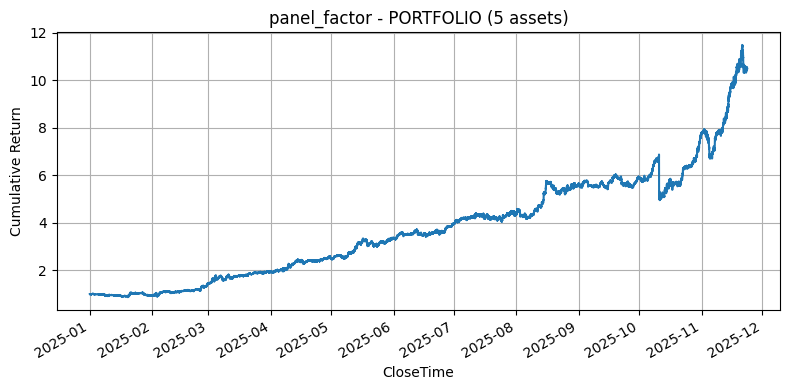


 IC Table (Year × Label) - panel_factor
 Values are average IC across 5 assets
          1m     2m     3m     5m    15m    30m     1h     2h     3h     6h     1d     2d     3d
Year                                                                                            
2022   0.004  0.005  0.005  0.006  0.006  0.002 -0.000  0.001 -0.001 -0.001 -0.000 -0.000 -0.002
2023   0.002  0.004  0.004  0.005  0.008  0.010  0.003  0.003  0.001  0.001  0.000  0.000 -0.002
2024   0.004  0.006  0.007  0.009  0.010  0.004  0.006  0.005  0.005  0.005  0.004  0.004  0.002
2025   0.005  0.006  0.006  0.008  0.008  0.009  0.008  0.002  0.004  0.002  0.003 -0.001  0.000
Total  0.004  0.005  0.006  0.007  0.008  0.006  0.004  0.003  0.002  0.002  0.002  0.001 -0.000


In [6]:
# ============================================================
# Panel Backtest - 因子值直接做仓位
# ============================================================
result = backtest_panel(
    factor_panel=factor_panel,
    panel=panel,               # 用于获取 returns
    factor_name=FACTOR_NAME,
    compound=True,
    plot=True,     
    mode='test',
    display=['average']            # 绘制平均累计收益曲线
)

[cs_momentum] Formula: clip(ts_ema(cs_rank_signed(ts_zscore(data, 60)), 5), -1, 1)

 Panel Backtest - cs_momentum (5 assets) [FULL]

[PORTFOLIO] Equal-weighted average position across 5 assets:
 Year Start Date   End Date  Long Ratio  Short Ratio  Return  Sharpe  Turnover  Ret/Turnover  Max Drawdown  Kamma Ratio
 2022 2022-01-01 2022-12-31        0.20          0.0  -20.48   -1.25     85.06       -0.0025         -0.22         0.92
 2023 2023-01-01 2023-12-31        0.21          0.0   32.79    2.46    170.79        0.0017         -0.08         4.19
 2024 2024-01-01 2024-12-31        0.20          0.0   21.92    1.48     50.13        0.0042         -0.09         2.35
 2025 2025-01-01 2025-11-23        0.20          0.0    0.90    0.14      0.10        0.1894         -0.12         0.07
Total 2022-01-01 2025-11-23        0.20          0.0   29.91    0.53     78.55        0.0039         -0.22         1.35
[Plot] Saved cumulative return to: /home/ch/data/result/plots/cumret_cs_momentum_20260

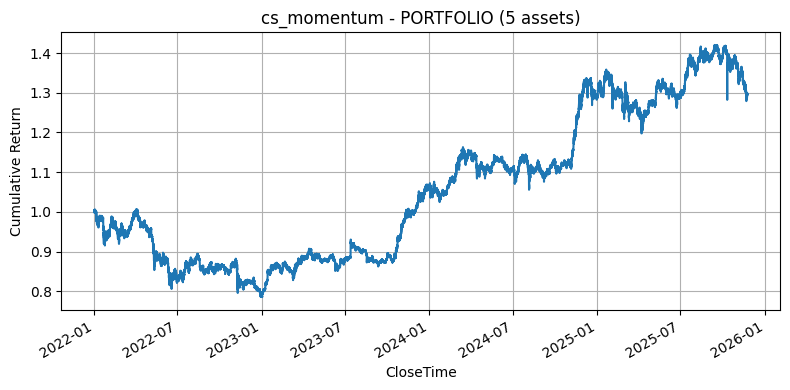


 IC Table (Year × Label) - cs_momentum
 Values are average IC across 5 assets
          1m     2m     3m     5m    15m    30m     1h     2h     3h     6h     1d     2d     3d
Year                                                                                            
2022  -0.017 -0.014 -0.012 -0.009 -0.006 -0.004  0.000  0.000  0.001  0.001  0.000  0.001  0.001
2023  -0.017 -0.015 -0.013 -0.010 -0.005 -0.004 -0.001 -0.002 -0.001 -0.000  0.002  0.004  0.004
2024  -0.013 -0.011 -0.009 -0.007 -0.003 -0.003 -0.001 -0.002 -0.002 -0.001  0.000  0.001  0.001
2025  -0.010 -0.009 -0.009 -0.007 -0.006 -0.004 -0.004 -0.003 -0.002 -0.002 -0.001 -0.001 -0.001
Total -0.014 -0.012 -0.011 -0.008 -0.005 -0.004 -0.002 -0.002 -0.001 -0.000  0.000  0.001  0.001


In [7]:
# ============================================================
# 示例：使用 CS 算子的因子（截面排名）
# ============================================================

def cs_momentum_factor(panel, ops):
    """
    截面动量因子 - 使用 CS 算子
    
    1. 计算收益率的 TS zscore
    2. 对 zscore 做 CS rank（截面排名）
    3. EMA 平滑
    """
    ret = panel['return']
    
    # TS 算子：对每个资产独立计算
    ts_zscore = ops.ts_zscore(ret, 60)
    
    # CS 算子：截面排名（跨资产排名）
    cs_rank = ops.cs_rank(ts_zscore)  # 输出 [0, 1]
    
    # 转换为 [-1, 1]
    cs_rank_signed = ops.cs_rank_signed(ts_zscore)
    
    # EMA 平滑
    factor = ops.ts_ema(cs_rank_signed, 5)
    
    return ops.clip(factor, -1, 1)


# 计算
cs_factor = compute_factor_panel(panel, cs_momentum_factor, 'cs_momentum')

# 回测 - 因子值直接做仓位
result_cs = backtest_panel(
    factor_panel=cs_factor,
    panel=panel,
    factor_name='cs_momentum',
    compound=True,
    plot=True,
)

[test_factor] Formula: clip(ts_zscore(-(((decay_linear((ts_argmax(data, 18) - 18), 4) + correlation(data, data, 49)) + rsi(data, 26)) - ts_zscore(data, 20)), 120), -3.0, 3.0)

 Panel Backtest - test_factor (5 assets) [FULL]

[ETH-USDT-SWAP]
 Year Start Date   End Date  Long Ratio  Short Ratio    Return  Sharpe  Turnover  Ret/Turnover  Max Drawdown  Kamma Ratio
 2022 2022-01-01 2022-12-31        0.46        -0.45    436.75    2.05 144297.47        0.0000         -0.74         5.93
 2023 2023-01-01 2023-12-31        0.45        -0.45   1199.68    3.86 144530.46        0.0000         -0.40        29.82
 2024 2024-01-01 2024-12-31        0.46        -0.46    613.98    2.66 144174.88        0.0000         -0.39        15.80
 2025 2025-01-01 2025-11-23        0.46        -0.45   1420.75    3.55 143285.65        0.0000         -0.36        38.96
Total 2022-01-01 2025-11-23        0.45        -0.45 757345.69    2.89 144093.49        0.0001         -0.74     10281.21
[Plot] Saved cumulative ret

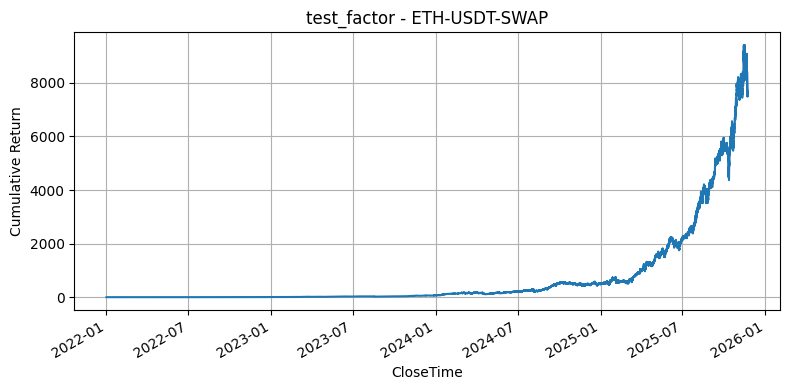


 IC Table (Year × Label) - test_factor
 Values are average IC across 5 assets
          1m     2m     3m     5m    15m    30m     1h     2h     3h     6h     1d     2d     3d
Year                                                                                            
2022   0.004  0.008  0.009  0.009  0.008  0.005  0.003  0.004  0.001 -0.002 -0.001  0.000 -0.000
2023   0.004  0.006  0.007  0.006  0.007  0.013  0.005  0.005  0.001  0.002  0.001  0.002  0.001
2024   0.005  0.005  0.006  0.007  0.009  0.003  0.004  0.005  0.005  0.001  0.002  0.002  0.001
2025   0.004  0.006  0.007  0.008  0.009  0.010  0.010  0.001  0.006  0.003  0.005  0.002  0.001
Total  0.004  0.006  0.007  0.008  0.008  0.008  0.006  0.004  0.003  0.001  0.002  0.002  0.001


In [8]:
# ============================================================
# 测试因子: -(decay_linear(ts_argmax(close, 18) - 18, 4) + corr(open, close, 49) + rsi(close, 26) - z_close_20)
# ============================================================

def test_factor(panel, ops):
    """
    因子公式: -(decay_linear(ts_argmax(close, 18) - 18, 4) + corr(open, close, 49) + rsi(close, 26) - z_close_20)
    """
    close = panel['Close']
    open_price = panel['Open']
    
    # 1. decay_linear(ts_argmax(close, 18) - 18, 4)
    argmax_close = ops.ts_argmax(close, 18)
    term1 = ops.decay_linear(argmax_close - 18, 4)
    
    # 2. corr(open, close, 49)
    term2 = ops.correlation(open_price, close, 49)
    
    # 3. rsi(close, 26)
    term3 = ops.rsi(close, 26)
    
    # 4. z_close_20 = ts_zscore(close, 20)
    z_close_20 = ops.ts_zscore(close, 20)
    
    # 组合: -(term1 + term2 + term3 - z_close_20)
    factor_val = -(term1 + term2 + term3 - z_close_20)
    
    # 标准化
    factor_val = ops.ts_zscore(factor_val, 120)
    factor_val = ops.clip(factor_val, -3.0, 3.0)
    
    return factor_val


# 计算因子
test_factor_panel = compute_factor_panel(panel, test_factor, 'test_factor')

# 回测
result_test = backtest_panel(
    factor_panel=test_factor_panel,
    panel=panel,
    factor_name='test_factor',
    compound=True,
    plot=True,
    display=['ETH-USDT-SWAP']
)

[ret_skew] Formula: strategy_signal(ts_ema(clip(ts_zscore(ts_skew(fill_na(returns(data, 1), 0), 600), 14400), -3, 3), 2), 2)

 Panel Backtest - ret_skew (5 assets) [FULL]

[BTC-USDT-SWAP]
 Year Start Date   End Date  Long Ratio  Short Ratio  Return  Sharpe  Turnover  Ret/Turnover  Max Drawdown  Kamma Ratio
 2022 2022-01-01 2022-12-31        0.50        -0.47  108.73    1.45    147.76        0.0064         -0.38         2.87
 2023 2023-01-01 2023-12-31        0.49        -0.51   32.36    0.85    166.03        0.0023         -0.35         0.94
 2024 2024-01-01 2024-12-31        0.56        -0.44   72.23    1.25    161.56        0.0043         -0.22         3.29
 2025 2025-01-01 2025-11-23        0.56        -0.44   18.33    0.64    187.71        0.0014         -0.36         0.50
Total 2022-01-01 2025-11-23        0.53        -0.47  463.04    1.09    165.19        0.0139         -0.38        12.23
[Plot] Saved cumulative return to: /home/ch/data/result/plots/cumret_ret_skew_20260126_19511

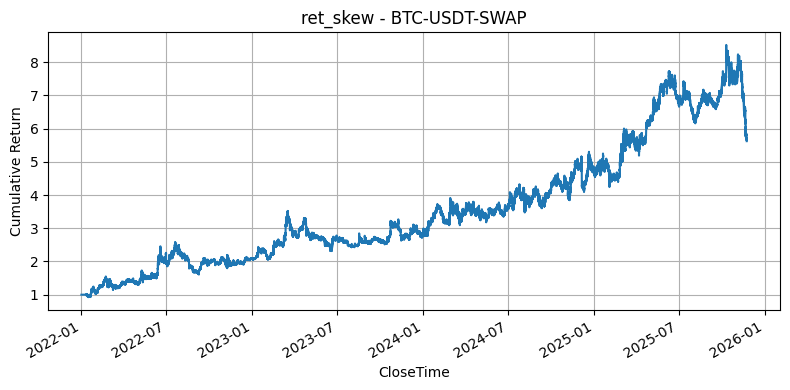


 IC Table (Year × Label) - ret_skew
 Values are average IC across 5 assets
          1m     2m     3m     5m    15m    30m     1h     2h     3h     6h     1d     2d     3d
Year                                                                                            
2022   0.000  0.001  0.001  0.001  0.002  0.003  0.003  0.003  0.003  0.004  0.009  0.002 -0.002
2023   0.000  0.001  0.001  0.001  0.001  0.002  0.003  0.004  0.004  0.004  0.018  0.041  0.039
2024  -0.001 -0.001 -0.001 -0.002 -0.003 -0.004 -0.006 -0.009 -0.012 -0.017 -0.041 -0.063 -0.088
2025   0.000  0.000  0.001  0.001  0.002  0.003  0.004  0.005  0.006  0.005  0.009 -0.011 -0.020
Total -0.000  0.000  0.000  0.000  0.000  0.001  0.001  0.001  0.000 -0.001 -0.001 -0.008 -0.018


In [9]:
# ============================================================
# 测试 ret_skew 因子（收益率偏度因子）
# ============================================================

def ret_skew_factor(panel, ops):
    """
    收益率偏度因子 - 基于 library.py 中的 RetSkewFactor
    
    公式: ts_ema(clip(ts_zscore(ts_skew(returns(close, 1), 600), 14400), -3, 3), 2)
    
    参数:
    - skew_window: 600 (计算偏度的窗口)
    - zscore_window: 14400 (标准化窗口)
    - ema_alpha: 2.0 (EMA平滑参数)
    """
    close = panel['Close']
    
    # 计算收益率
    ret = ops.returns(close, 1)
    ret = ops.fill_na(ret)
    
    # 计算滚动偏度
    skew = ops.ts_skew(ret, 600)
    
    # Z-score 标准化
    zscore = ops.ts_zscore(skew, 14400)
    
    # Clip 到 [-3, 3]
    clipped = ops.clip(zscore, -3, 3)
    
    # EMA 平滑
    factor_val = ops.ts_ema(clipped, 2)
    
    # 生成策略信号 (threshold=2)
    factor_val = ops.strategy_signal(factor_val, 2)
    
    return factor_val


# 计算因子
ret_skew_panel = compute_factor_panel(panel, ret_skew_factor, 'ret_skew')


# 回测
result_skew = backtest_panel(
    factor_panel=ret_skew_panel,
    panel=panel,
    factor_name='ret_skew',
    compound=True,
    plot=True,
    display=['BTC-USDT-SWAP']
)